In [1]:
import pandas as pd
import numpy as np
import time
import json

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

import math as mt
from scipy.sparse.linalg import * 
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix

In [2]:
reviews = []

with open('reviews_Musical_Instruments_5.json', 'r') as f:
    raw_json = f.readlines()
    for record in raw_json:
        reviews.append(eval(record))

In [3]:
json_info = json.dumps(reviews)

df = pd.read_json(json_info)
df = df[['reviewerID', 'asin', 'overall']].copy()
df.sample(10)

,reviewerID,asin,overall
7024,AJK15Q9JOEHRH,B001W99HE8,5
8158,A32H7YO8K1XS9E,B003VWJ2K8,5
5059,AQDHNCD25PFE6,B000LPUV8K,5
6966,A3E7O9NSS47TE8,B001RNHE30,5
373,A2NYK9KWFMJV4Y,B0002CZUUG,5
160,A1L7M2JXN4EZCR,B00006LVEU,4
4178,A2RS66Y79Q8X0W,B000AKSUP2,5
2466,A21N9ACLVOMDLP,B0002GW3Y8,4
7058,AKSFZ4G1AXYFC,B0023BYDHK,3
3616,A1J9HY0AG5676,B0006H92QK,5


In [4]:
df.shape

(10261, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 3 columns):
reviewerID    10261 non-null object
asin          10261 non-null object
overall       10261 non-null int64
dtypes: int64(1), object(2)
memory usage: 240.6+ KB


In [6]:
instruments = df.groupby('asin')['overall'].mean()
instruments.describe()

count    900.000000
mean       4.464891
std        0.403301
min        2.714286
25%        4.285714
50%        4.547727
75%        4.777778
max        5.000000
Name: overall, dtype: float64

In [7]:
users = df.groupby('reviewerID')['overall'].count()
users.describe()

count    1429.000000
mean        7.180546
std         3.731858
min         5.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        42.000000
Name: overall, dtype: float64

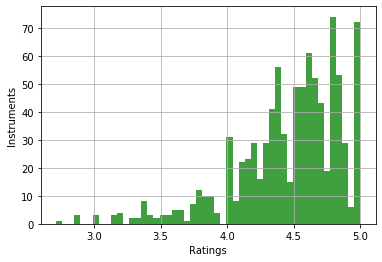

In [8]:
plt.hist(instruments, 50, facecolor='green', alpha=0.75)
plt.xlabel('Ratings')
plt.ylabel('Instruments')
plt.grid(True)
plt.show()

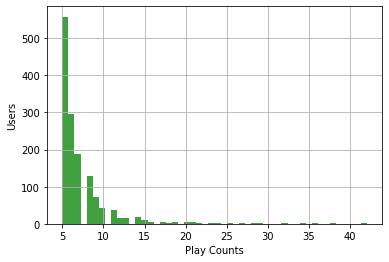

In [9]:
plt.hist(users, 50, facecolor='green', alpha=0.75)
plt.xlabel('Play Counts')
plt.ylabel('Users')
plt.grid(True)
plt.show()

In [10]:
df[df.reviewerID =='A1CF9IF5FWYNU0'].head()

,reviewerID,asin,overall
1337,A1CF9IF5FWYNU0,B0002E1G5C,2
2889,A1CF9IF5FWYNU0,B0002H0A3S,5
7348,A1CF9IF5FWYNU0,B002KDHBRU,2
8362,A1CF9IF5FWYNU0,B003VWKPHC,5
8845,A1CF9IF5FWYNU0,B004VDD4KK,5


In [13]:
user_codes = df.reviewerID.drop_duplicates().reset_index()
product_codes = df.asin.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
product_codes.rename(columns={'index':'product_index'}, inplace=True)

product_codes['p_index_value'] = list(product_codes.index)
user_codes['u_index_value'] = list(user_codes.index)
df = pd.merge(df,product_codes,how='left')
df = pd.merge(df,user_codes,how='left')

mat_candidate = df[['u_index_value','p_index_value','overall']]
data_array = mat_candidate.overall.values
row_array = mat_candidate.u_index_value.values
col_array = mat_candidate.p_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

In [15]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

In [16]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)

In [17]:
uTest = [1,2,3,4,5,6,7,8,9,10]
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

In [19]:
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        product_details = df[df.p_index_value == i].drop_duplicates('p_index_value')[['asin']]
        print("The number {} recommended song is {}".format(rank_value, list(product_details['asin'])[0]))
        rank_value+=1

Recommendation for user with user id 1
The number 1 recommended song is B004XNK7AI
The number 2 recommended song is B0002GMGYA
The number 3 recommended song is B0002E1O2C
The number 4 recommended song is B0002CZSJO
The number 5 recommended song is B0002M6CW6
The number 6 recommended song is B000B6DHB2
The number 7 recommended song is B000A6ASSS
The number 8 recommended song is B000EELB8W
The number 9 recommended song is B000B6FBA2
The number 10 recommended song is B000OMG0KI
Recommendation for user with user id 2
The number 1 recommended song is B0002CZW0Y
The number 2 recommended song is B0002M3OVI
The number 3 recommended song is B000LQLDM2
The number 4 recommended song is B000NJ2TIE
The number 5 recommended song is B0002GXF8Q
The number 6 recommended song is B000J5XS3C
The number 7 recommended song is B003GEBGA0
The number 8 recommended song is B0018TAITA
The number 9 recommended song is B000VJJQUU
The number 10 recommended song is B000EELB8W
Recommendation for user with user id 3
T